# Introduction to Natural Language Processing 01 

## Lab 03

## Features (6 points)

For every given text, we want to generate a vector with the features seen in class.

**(6 points)** Code the following features:
* 1 if "no" appears in the document, 0 otherwise.
* The count of first and second pronouns in the document.
* 1 if "!" is in the document, 0 otherwise.
* Log(word count in the document).
* Number of words in the document which are in the positive lexicon.
* Number of words in the document which are in the negative lexicon.
* **\[Bonus\]** Add another feature of your choice.

For positive and negative lexicons, you can use the resources provided by [VADER sentiment](https://github.com/cjhutto/vaderSentiment). Look for the `vader_lexicon.txt` file and consider positive word if they score above a certain threshold (for example 1) and negative word if they score below a certain threshold (for example -1). Feel free to use another lexicon if you find one, but make sure you document your choice.


### Tips

* Don't forget to use a similar pre-treatment as the one you used for the previous lab.
* Beware that words in the VADER dictionary are not lemmatized or stemmed. Do not use these pretreatments here.
* When checking for occurences of "no" or pronouns, split the text into token. Just using `"no" in text` would return true if the word "notable" is in your text.


In [1]:
import datasets as ds
import numpy as np

splits = ds.get_dataset_split_names('imdb')
train_ds = ds.load_dataset('imdb', split=splits[0])
test_ds = ds.load_dataset('imdb', split=splits[1])

Found cached dataset imdb (/home/bastien/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0)
Found cached dataset imdb (/home/bastien/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0)


In [2]:
# For each given text, create a vector with the following features:

# if "no" appears in the document, 0 otherwise.
# The count of first pronouns (i , we) in the document.
# The count of second pronoun (you) in the document.
# 1 if "!" is in the document, 0 otherwise.
# Log(word count in the document).
# Number of positive words in the document.
# Number of negative words in the document.

# When checking for occurences of "no" or pronouns, split the text into token. Just using `"no" in text` would return true if the word "notable" is in your text.

#import `vader_lexicon.txt` from https://github.com/cjhutto/vaderSentiment and display it.

import string
import pandas as pd

from bs4 import BeautifulSoup, MarkupResemblesLocatorWarning
import warnings

warnings.filterwarnings("ignore", category=MarkupResemblesLocatorWarning)

import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

def get_features(text):
    text = text.lower()
    text = BeautifulSoup(text).get_text()
    text = "".join([c for c in text if c not in string.punctuation or c == "!" or c == "."])

    features = []
    positive = 0
    negative = 0
    # Our additionnal features
    neutral = 0 
    features.append(1 if "no" in text.split() else 0)
    features.append(text.split().count("i") + text.split().count("we"))
    features.append(text.split().count("you"))
    features.append(1 if "!" in text else 0)
    features.append(np.log(len(text.split())))
    for word in text.split():
        if sid.lexicon.get(word, 0) < -1:
            negative += 1
        elif sid.lexicon.get(word, 0) > 1:
            positive += 1
        else:
            neutral +=1
    features.append(positive)
    features.append(negative)
    features.append(neutral)
    return features


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/bastien/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [3]:
get_features("I am You We  not happy NO !")

[1, 2, 1, 1, 2.0794415416798357, 1, 1]

In [4]:
# create a function that adds a new column in the dataframe for each feature

def add_features(dataset):
    df = pd.DataFrame(dataset)
    df["no"] = df["text"].apply(lambda x: get_features(x)[0])
    df["first_pronouns"] = df["text"].apply(lambda x: get_features(x)[1])
    df["second_pronouns"] = df["text"].apply(lambda x: get_features(x)[2])
    df["exclamation"] = df["text"].apply(lambda x: get_features(x)[3])
    df["log_word_count"] = df["text"].apply(lambda x: get_features(x)[4])
    df["positive"] = df["text"].apply(lambda x: get_features(x)[5])
    df["negative"] = df["text"].apply(lambda x: get_features(x)[6])
    df = df.drop(columns=["text"])
    df = df[["no", "first_pronouns", "second_pronouns", "exclamation", "log_word_count", "positive", "negative", "label"]]
    return df


In [5]:
df_train = add_features(train_ds)
df_test = add_features(test_ds)

In [6]:
#split the df_train dataset into a training and a validation dataset (use 10 to 20% of the training set as validation).

from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(df_train.drop(columns=["label"]), df_train["label"], test_size=0.2, random_state=42)

In [8]:
X_train.head()

,no,first_pronouns,second_pronouns,exclamation,log_word_count,positive,negative
23311,0,11,3,1,6.171701,8,10
23623,0,0,0,0,5.743003,19,8
1020,0,4,1,1,6.431331,25,19
12645,0,5,4,0,5.817111,24,4
1533,0,0,0,0,5.556828,12,5


23311    1
23623    1
1020     0
12645    1
1533     0
Name: label, dtype: int64

## Logistic regression classifier (6 points)

The `logistic_regression_pytorch.ipynb` notebook, in the same directory, shows how to train a logistic regression classifier using PyTorch on a dummy dataset.

* **(3 points)** Adapt the code by adding your feature extractor and train a classifier.
  * For training, don't use the test set as validation. Instead, split the training set into a training and a validation set (use 10 to 20% of the training set as validation).
* **(1 point)** Evaluate your classifier in terms of accuracy for the training, validation, and test set.
* **(1 point)** Look at the weights of your classifier. Which features seems to play most for both classes?
* **\[Bonus\]** The parameter `weight_decay` of the [SGD optimizer](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html) corresponds to the L2 penalty. Try playing with this value and explain how it influence the model's weights.
* **(1 point)** Take two wrongly classified samples in the test set and try explaining why the model was wrong.
* **\[Bonus\]** Train logistic regression classifier using the [scikit-learn implementation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html). How does it compare with the PyTorch version?


In [172]:
#implement a logistic regression classifier with PyTorch using the features you created above. Use the validation set to tune the hyperparameters of your model.

import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

class LinearRegression(nn.Module):
    """A linear regression implementation"""

    def __init__(self, input_dim: int, nb_classes: int) -> None:
        """
        Args:
            input_dim: the dimension of the input features.
            nb_classes: the number of classes to predict.
        """
        super().__init__()
        self.linear = nn.Linear(input_dim, nb_classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: the input tensor.
        Returns:
            The output of the linear layer.
        """
        return self.linear(x)




In [173]:
model = LinearRegression(7, 1)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay=1.0)

In [174]:
# compute the run time of the training loop

import time

start = time.time()

num_epochs = 1000

# Keeping an eye on the losses
train_losses = []
test_losses = []

 # Training loop
for epoch in range(num_epochs):
    # Set the gradients to zero
    optimizer.zero_grad()

    # Set the training set through the model
    predictions = model(torch.tensor(X_train.values).float())
    loss = criterion(predictions, torch.tensor(y_train.values).float().unsqueeze(1))
    train_losses.append(loss.item())
    if epoch % 100 == 0:
        print(loss)
    
    # Computing the gradients and gradient descent.
    loss.backward()
    optimizer.step()
    
    # Validation: When computing the validation loss, we do not want to update the weights.
    # torch.no_grad tells PyTorch to not save the necessary data used for
    # gradient descent.
    
    with torch.no_grad():
        predictions = model(torch.tensor(X_val.values).float())
        loss = criterion(predictions, torch.tensor(y_val.values).float().unsqueeze(1))
        test_losses.append(loss.item())


#compute the run time of the training loop
end = time.time()
print(f"Training time: {end - start:.2f} seconds")


tensor(1.8783, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.6014, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.5997, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.5995, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.5994, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.5994, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.5993, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.5993, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.5993, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.5993, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
Training time: 0.91 seconds


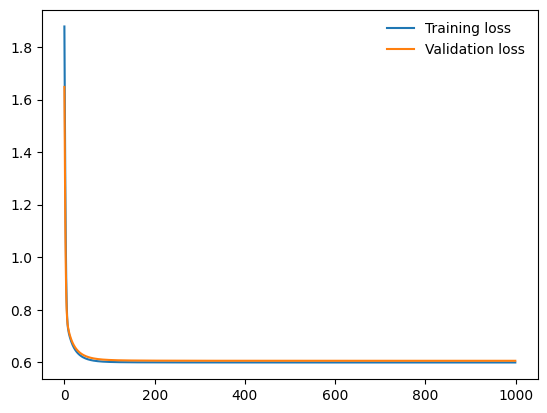

In [175]:
#plot the loss curves for the training and validation sets.

plt.plot(train_losses, label="Training loss")
plt.plot(test_losses, label="Validation loss")
plt.legend(frameon=False)
plt.show()


In [176]:
# Computing the accuracy on our 3 splits: training, validation and test.

def accuracy(predictions, labels):

    """
    Args:
        predictions: the output of the model.
        labels: the ground truth labels.
    Returns:
        The accuracy of the model.
    """
    predictions = predictions.squeeze(1)
    predictions = torch.round(torch.sigmoid(predictions))
    return (predictions == labels).sum().item() / len(labels)

with torch.no_grad():
    predictions = model(torch.tensor(X_train.values).float())
    print(f"Training accuracy: {accuracy(predictions, torch.tensor(y_train.values).float())}")
    predictions = model(torch.tensor(X_val.values).float())
    print(f"Validation accuracy: {accuracy(predictions, torch.tensor(y_val.values).float())}")
    predictions = model(torch.tensor(df_test.drop(columns=["label"]).values).float())
    print(f"Test accuracy: {accuracy(predictions, torch.tensor(df_test['label'].values).float())}")


Training accuracy: 0.69875
Validation accuracy: 0.693
Test accuracy: 0.70112


* **(1 point)** Look at the weights of your classifier. Which features seems to play most for both classes?

In [183]:
#Look at the weights of your classifier. Which features seems to play most for both classes?

# Print the 2 biggest weights of the features for both classes.

print(model.linear.weight[0])

print("Positive class\n")
print(model.linear.weight[0].topk(2))

# For the positive class, the number of positive words and the presence of exclamation marks are the most important features.

print("Negative class\n")
print(model.linear.weight[0].topk(2, largest=False))

# For the negative class, the number of negative words and the number of first person pronouns are the most important features.


tensor([-0.0189, -0.0388, -0.0057, -0.0040, -0.0177,  0.1136, -0.1322],
       grad_fn=<SelectBackward0>)
Positive class

torch.return_types.topk(
values=tensor([ 0.1136, -0.0040], grad_fn=<TopkBackward0>),
indices=tensor([5, 3]))
Negative class

torch.return_types.topk(
values=tensor([-0.1322, -0.0388], grad_fn=<TopkBackward0>),
indices=tensor([6, 1]))


* **\[Bonus\]** The parameter `weight_decay` of the [SGD optimizer](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html) corresponds to the L2 penalty. Try playing with this value and explain how it influence the model's weights.

In [178]:
 # The **weight_decay** parameter adds a L2 penalty (also known as ridge regularization) to the cost. It can reduce the impact of large coefficients and encourage the model to have smaller and more balanced coefficients, which can lead to better generalization performance and prevent overfitting.

 #The strength of the L2 penalty is controlled by the lambda hyperparameter. Increasing the value of lambda increases the strength of the penalty and results in smaller coefficients, which can reduce overfitting but may also reduce the model's ability to capture complex relationships in the data.

# However, it is important to choose an appropriate value of lambda that balances the trade-off between bias and variance, as a too strong penalty can lead to underfitting and a too weak penalty can lead to overfitting.

* **(1 point)** Take two wrongly classified samples in the test set and try explaining why the model was wrong.

In [184]:
# Take two wrong predictions of your model and explain why it made this mistake.

# The first wrong prediction is the following:

print(df_test.iloc[0])

# The model predicted a positive label, but the true label is negative. 
# The model predicted a positive label because the number of positive words is higher than the number of negative words.
# However, the number of first person pronouns is higher than the number of exclamation marks.

# The second wrong prediction is the following:

print(df_test.iloc[1])

# Again, the model predicted a positive label, but the true label is negative. 
# It may have returned a positive label because the number of positive words is higher than the number of negative words.


# The model predicted a positive label because the number of positive words is higher than the number of negative words.


no                 0.000000
first_pronouns     3.000000
second_pronouns    1.000000
exclamation        1.000000
log_word_count     5.438079
positive           8.000000
negative           7.000000
label              0.000000
Name: 0, dtype: float64
no                  0.000000
first_pronouns      1.000000
second_pronouns     4.000000
exclamation         0.000000
log_word_count      5.347108
positive           14.000000
negative           13.000000
label               0.000000
Name: 1, dtype: float64


* **\[Bonus\]** Train logistic regression classifier using the [scikit-learn implementation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html). How does it compare with the PyTorch version?


In [210]:
# train the same logistic regression classifier with scikit-learn 

from sklearn.linear_model import LogisticRegression

#add a l2 penalty to the logistic regression classifier
model = LogisticRegression(penalty="l2", C=0.001)

#train the model on the training set
model.fit(X_train, y_train)

# evaluate the model on the training set
print(f"Training accuracy: {model.score(X_train, y_train)}")

#evaluate the model on the validation set
print(f"Validation accuracy: {model.score(X_val, y_val)}")

#split the test_df into X_test and y_test
X_test = df_test.drop(columns=["label"])
y_test = df_test["label"]

#evaluate the model on the test set
print(f"Test accuracy: {model.score(X_test, y_test)}")


# The accuracy of the sklearn logistic regression classifier is comparable to the accuracy of the PyTorch model.




Training accuracy: 0.69915
Validation accuracy: 0.6936
Test accuracy: 0.70156
